In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


# Generate data

In [ ]:
# y without noises
lstX=[]
lstY=[]
for i in range(5000):
  x1 = np.random.normal(0.1, 0.5) # mean and standard deviation
  x2 = np.random.normal(6, 0.8)
  x3 = np.random.normal(0.5, 0.8)
  x4 = np.random.normal(0.1, 3.5)
  x5 = np.random.normal(5, 0.7)
  x6 = np.random.normal(0.2, 0.3)
  x7 = np.random.normal(0, 0.3)
  y = 0.455*pow(x1,3)+0.111*x2+2.22*pow(x3,4)+7.88*pow(x4,3)+0.222*pow(x5,2)*x6+0.777*pow(x7,2)
  lstX.append([x1, x2, x3, x4, x5, x6, x7])
  lstY.append([y])

In [ ]:
numpyX = np.array(lstX)
numpyY = np.array(lstY)
print(np.max(numpyY), np.min(numpyY), np.mean(numpyY), np.std(numpyY))

249.70950929315498 -9.42797098521392 15.315541499557897 19.59917294774047


# Build NN

In [ ]:
MyNet = nn.Sequential(
    nn.Linear(7, 56),
    nn.ReLU(),
    nn.Linear(56, 56),
    nn.ReLU(),
    nn.Linear(56, 1),
)
MyNet.to(device)
print(MyNet)

Sequential(
  (0): Linear(in_features=7, out_features=56, bias=True)
  (1): ReLU()
  (2): Linear(in_features=56, out_features=56, bias=True)
  (3): ReLU()
  (4): Linear(in_features=56, out_features=1, bias=True)
)


# Run training-test 20 times

In [ ]:
train_lossLst = []
test_lossLst = []
for i in range(1, 11):
  print("\nTrain-test ", i, end= " ")
  trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY = torch.FloatTensor(trainY).to(device)
  torch_dataset = Data.TensorDataset(tensorX, tensorY)
  loader = Data.DataLoader(
      dataset=torch_dataset,
      batch_size=500,
      shuffle=True,
      num_workers=0,    # subprocesses for loading data
  )

  # initialize NN weights
  for name, param in MyNet.named_parameters():
    if(param.requires_grad):
      torch.nn.init.normal_(param, mean=0.0, std=0.02)
  loss_func = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003)

  # train NN
  print("epoch", end=": ")
  epoch_lossLst=[]
  for epoch in range(1, 300):
    if(epoch%100 == 0):
      print(epoch, end=",")
    for (batchX, batchY) in loader:
      batchY_hat = MyNet(batchX)
      loss = loss_func(batchY_hat, batchY)
      epoch_lossLst.append(float(loss))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_lossLst.append(epoch_lossLst)

  tensorX = torch.FloatTensor(testX).to(device)
  tensorY = torch.FloatTensor(testY).to(device)
  tensorY_hat = MyNet(tensorX)
  loss = loss_func(tensorY, tensorY_hat)
  test_lossLst.append(float(loss))


Train-test  1 epoch: 100,200,
Train-test  2 epoch: 100,200,
Train-test  3 epoch: 100,200,
Train-test  4 epoch: 100,200,
Train-test  5 epoch: 100,200,
Train-test  6 epoch: 100,200,
Train-test  7 epoch: 100,200,
Train-test  8 epoch: 100,200,
Train-test  9 epoch: 100,200,
Train-test  10 epoch: 100,200,

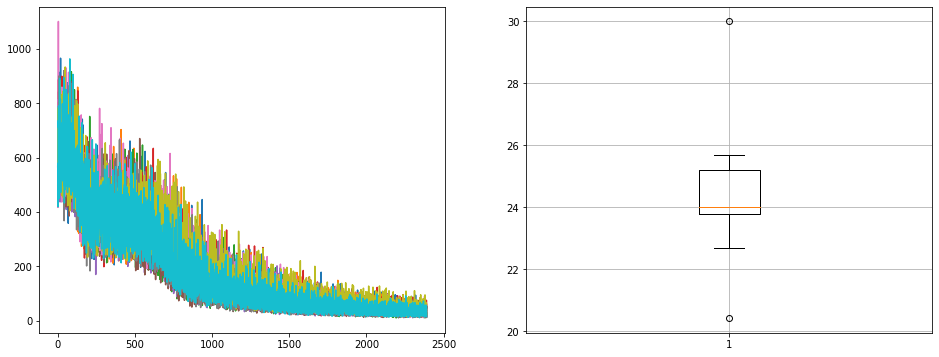

In [ ]:
#take a look at the train loss plot and box plot of test lost
fig=plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1) #1 row, 2 cols
for lst in train_lossLst:
  plt.plot(lst)
fig.add_subplot(1, 2, 2)
plt.boxplot(test_lossLst)
plt.grid()
plt.show()

# Solve overfitting (1) - Early stop

In [ ]:
train_lossLst = []
test_lossLst = []
for i in range(1, 21):
  print("\nTrain-test ", i, end= " ")
  trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
  trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.10, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY = torch.FloatTensor(trainY).to(device)
  torch_dataset = Data.TensorDataset(tensorX, tensorY)
  loader = Data.DataLoader(
      dataset=torch_dataset,
      batch_size=500,
      shuffle=True,
      num_workers=0,    # subprocesses for loading data
  )

  # initialize NN weights
  for name, param in MyNet.named_parameters():
    if(param.requires_grad):
      torch.nn.init.normal_(param, mean=0.0, std=0.02)
  loss_func = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003)

  # train NN
  # Early stopping parameters
  the_last_loss = 100000
  patience = 5
  trigger_times = 0
  print("epoch", end=": ")
  epoch_lossLst=[]
  for epoch in range(1, 300):
    if(epoch%100 == 0):
      print(epoch, end=",")
    for (batchX, batchY) in loader:
      batchY_hat = MyNet(batchX)
      loss = loss_func(batchY_hat, batchY)
      epoch_lossLst.append(float(loss))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    tensor_validationX = torch.FloatTensor(validationX).to(device)
    tensor_validationY = torch.FloatTensor(validationY).to(device)
    tensor_validationY_hat = MyNet(tensor_validationX)
    validatiion_loss = loss_func(tensor_validationY, tensor_validationY_hat)

    #early stop
    the_current_loss = float(validatiion_loss)
    if(the_current_loss > the_last_loss):
      trigger_times += 1
      print('trigger times:', trigger_times)
      if(trigger_times >= patience):
        print('Early stopping!')
        break  # early stop when validation loss increases 2 consective times
    elif(trigger_times >0):
      print('trigger times reset to 0')
      trigger_times = 0
    the_last_loss = the_current_loss
  train_lossLst.append(epoch_lossLst)

  tensorX = torch.FloatTensor(testX).to(device)
  tensorY = torch.FloatTensor(testY).to(device)
  tensorY_hat = MyNet(tensorX)
  loss = loss_func(tensorY, tensorY_hat)
  test_lossLst.append(float(loss))


Train-test  1 epoch: 100,200,trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times: 2
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0

Train-test  2 epoch: 100,trigger times: 1
trigger times reset to 0
200,trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times: 2
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger times reset to 0
trigger times: 1
trigger

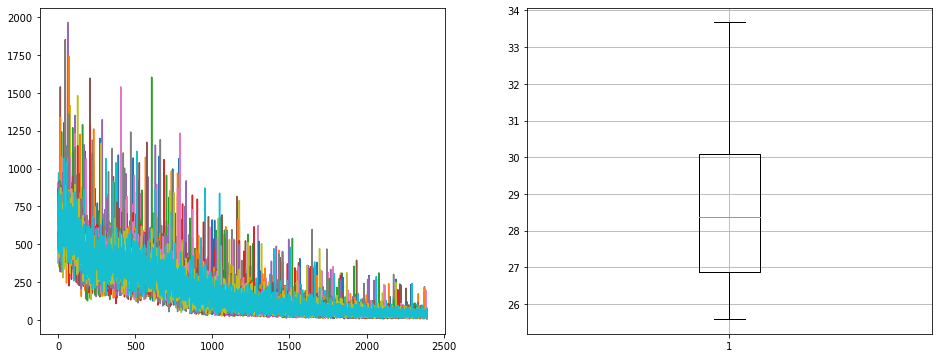

In [ ]:
#take a look at the train loss plot and box plot of test lost
fig=plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1) #1 row, 2 cols
for lst in train_lossLst:
  plt.plot(lst)
fig.add_subplot(1, 2, 2)
plt.boxplot(test_lossLst)
plt.grid()
plt.show()

# Solve overfitting (2) - L2 regularization
optimizer = torch.optim.Adam(MyNet.parameters(), lr=..., weight_decay=0.0001)

In [ ]:
train_lossLst = []
test_lossLst = []
for i in range(1,11):
  print("\nTrain-test ", i, end= " ")
  trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY = torch.FloatTensor(trainY).to(device)
  torch_dataset = Data.TensorDataset(tensorX, tensorY)
  loader = Data.DataLoader(
      dataset=torch_dataset,
      batch_size=500,
      shuffle=True,
      num_workers=0,    # subprocesses for loading data
  )

  # initialize NN weights
  for name, param in MyNet.named_parameters():
    if(param.requires_grad):
      torch.nn.init.normal_(param, mean=0.0, std=0.02)
  loss_func = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003, weight_decay=0.2)

  # train NN
  print("epoch", end=": ")
  epoch_lossLst=[]
  for epoch in range(1, 300):
    if(epoch%100 == 0):
      print(epoch, end=",")
    for (batchX, batchY) in loader:
      batchY_hat = MyNet(batchX)
      loss = loss_func(batchY_hat, batchY)
      epoch_lossLst.append(float(loss))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_lossLst.append(epoch_lossLst)

  tensorX = torch.FloatTensor(testX).to(device)
  tensorY = torch.FloatTensor(testY).to(device)
  tensorY_hat = MyNet(tensorX)
  loss = loss_func(tensorY, tensorY_hat)
  test_lossLst.append(float(loss))


Train-test  1 epoch: 100,200,
Train-test  2 epoch: 100,200,
Train-test  3 epoch: 100,200,
Train-test  4 epoch: 100,200,
Train-test  5 epoch: 100,200,
Train-test  6 epoch: 100,200,
Train-test  7 epoch: 100,200,
Train-test  8 epoch: 100,200,
Train-test  9 epoch: 100,200,
Train-test  10 epoch: 100,200,

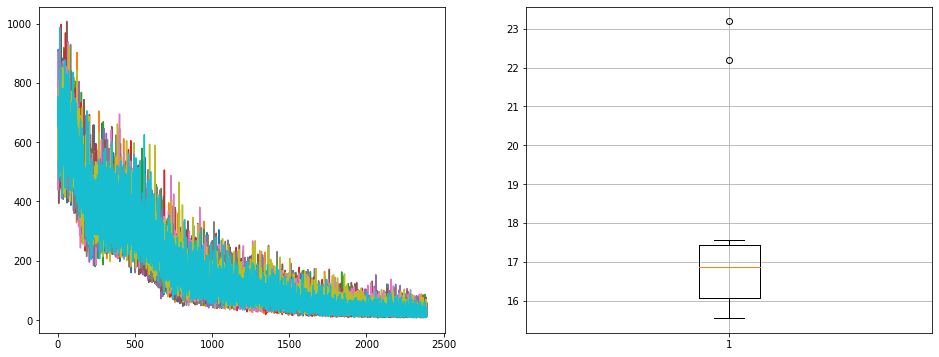

In [ ]:
#take a look at the train loss plot and box plot of test lost
fig=plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1) #1 row, 2 cols
for lst in train_lossLst:
  plt.plot(lst)
fig.add_subplot(1, 2, 2)
plt.boxplot(test_lossLst)
plt.grid()
plt.show()

# Solve overfitting (2) - L1 regularization

In [ ]:
lamda = 0.001

In [ ]:
train_lossLst = []
test_lossLst = []
for i in range(1, 21):
  print("\nTrain-test ", i, end= " ")
  trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY = torch.FloatTensor(trainY).to(device)
  torch_dataset = Data.TensorDataset(tensorX, tensorY)
  loader = Data.DataLoader(
      dataset=torch_dataset,
      batch_size=500,
      shuffle=True,
      num_workers=0,    # subprocesses for loading data
  )

  # initialize NN weights
  for name, param in MyNet.named_parameters():
    if(param.requires_grad):
      torch.nn.init.normal_(param, mean=0.0, std=0.02)
  loss_func = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003)

  # train NN
  print("epoch", end=": ")
  epoch_lossLst=[]
  for epoch in range(1, 300):
    if(epoch%100 == 0):
      print(epoch, end=",")
    for (batchX, batchY) in loader:
      batchY_hat = MyNet(batchX)
      loss = loss_func(batchY_hat, batchY)
      epoch_lossLst.append(float(loss))

      # add L1 regularization
      regularization_loss = 0
      for name, param in MyNet.named_parameters():
        if('weight' in name):
          regularization_loss += torch.sum(abs(param))
      loss = loss + lamda * regularization_loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_lossLst.append(epoch_lossLst)

  tensorX = torch.FloatTensor(testX).to(device)
  tensorY = torch.FloatTensor(testY).to(device)
  tensorY_hat = MyNet(tensorX)
  loss = loss_func(tensorY, tensorY_hat)
  test_lossLst.append(float(loss))


Train-test  1 epoch: 100,200,
Train-test  2 epoch: 100,200,
Train-test  3 epoch: 100,200,
Train-test  4 epoch: 100,200,
Train-test  5 epoch: 100,200,
Train-test  6 epoch: 100,200,
Train-test  7 epoch: 100,200,
Train-test  8 epoch: 100,200,
Train-test  9 epoch: 100,200,
Train-test  10 epoch: 100,200,
Train-test  11 epoch: 100,200,
Train-test  12 epoch: 100,200,
Train-test  13 epoch: 100,200,
Train-test  14 epoch: 100,200,
Train-test  15 epoch: 100,200,
Train-test  16 epoch: 100,200,
Train-test  17 epoch: 100,200,
Train-test  18 epoch: 100,200,
Train-test  19 epoch: 100,200,
Train-test  20 epoch: 100,200,

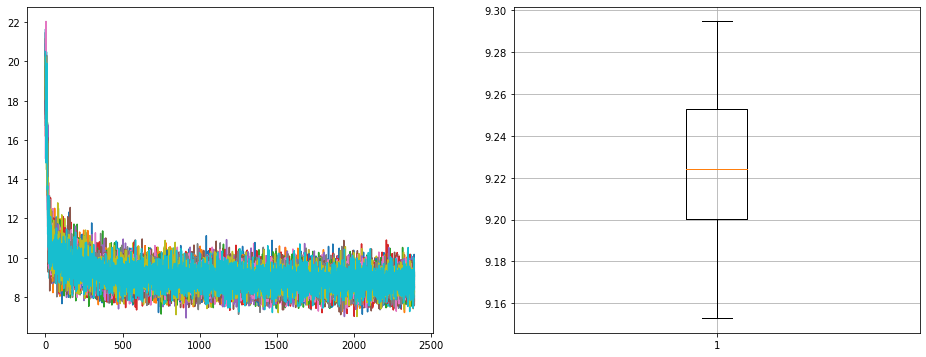

In [ ]:
#take a look at the train loss plot and box plot of test lost
fig=plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1) #1 row, 2 cols
for lst in train_lossLst:
  plt.plot(lst)
fig.add_subplot(1, 2, 2)
plt.boxplot(test_lossLst)
plt.grid()
plt.show()

# Solve overfitting (3) - Drop out

In [ ]:
MyNet = nn.Sequential(
    nn.Linear(7, 56),
    nn.ReLU(),
    nn.Dropout(p=0.8),
    nn.Linear(56, 56),
    nn.ReLU(),
    nn.Dropout(p=0.8),
    nn.Linear(56, 1),
)
MyNet.to(device)
print(MyNet)

Sequential(
  (0): Linear(in_features=7, out_features=56, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.8, inplace=False)
  (3): Linear(in_features=56, out_features=56, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.8, inplace=False)
  (6): Linear(in_features=56, out_features=1, bias=True)
)


In [ ]:
train_lossLst = []
test_lossLst = []
for i in range(1, 21):
  print("\nTrain-test ", i, end= " ")
  trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY = torch.FloatTensor(trainY).to(device)
  torch_dataset = Data.TensorDataset(tensorX, tensorY)
  loader = Data.DataLoader(
      dataset=torch_dataset,
      batch_size=500,
      shuffle=True,
      num_workers=0,    # subprocesses for loading data
  )

  # initialize NN weights
  for name, param in MyNet.named_parameters():
    if(param.requires_grad):
      torch.nn.init.normal_(param, mean=0.0, std=0.02)
  loss_func = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003)

  # train NN
  print("epoch", end=": ")
  epoch_lossLst=[]
  for epoch in range(1, 300):
    if(epoch%100 == 0):
      print(epoch, end=",")
    for (batchX, batchY) in loader:
      batchY_hat = MyNet(batchX)
      loss = loss_func(batchY_hat, batchY)
      epoch_lossLst.append(float(loss))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_lossLst.append(epoch_lossLst)

  #model.eval() will turn model to test mode and PyTorch will
  # automatically handle weight scaling of the dropout layer
  MyNet.eval()
  tensorX = torch.FloatTensor(testX).to(device)
  tensorY = torch.FloatTensor(testY).to(device)
  tensorY_hat = MyNet(tensorX)
  loss = loss_func(tensorY, tensorY_hat)
  test_lossLst.append(float(loss))


Train-test  1 epoch: 100,200,
Train-test  2 epoch: 100,200,
Train-test  3 epoch: 100,200,
Train-test  4 epoch: 100,200,
Train-test  5 epoch: 100,200,
Train-test  6 epoch: 100,200,
Train-test  7 epoch: 100,200,
Train-test  8 epoch: 100,200,
Train-test  9 epoch: 100,200,
Train-test  10 epoch: 100,200,
Train-test  11 epoch: 100,200,
Train-test  12 epoch: 100,200,
Train-test  13 epoch: 100,200,
Train-test  14 epoch: 100,200,
Train-test  15 epoch: 100,200,
Train-test  16 epoch: 100,200,
Train-test  17 epoch: 100,200,
Train-test  18 epoch: 100,200,
Train-test  19 epoch: 100,200,
Train-test  20 epoch: 100,200,

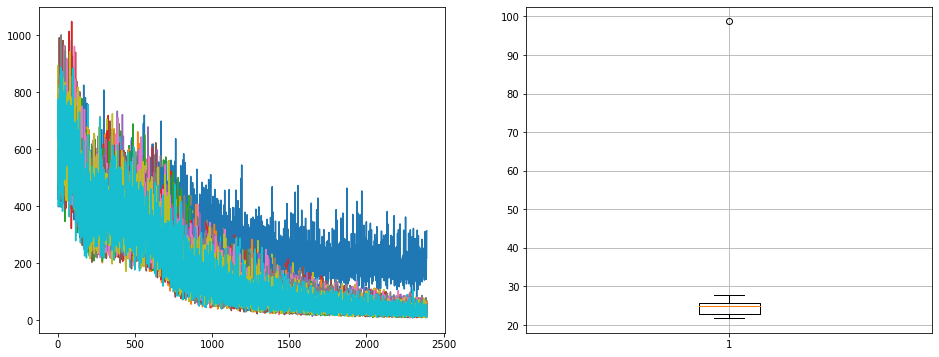

In [ ]:
#take a look at the train loss plot and box plot of test lost
fig=plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1) #1 row, 2 cols
for lst in train_lossLst:
  plt.plot(lst)
fig.add_subplot(1, 2, 2)
plt.boxplot(test_lossLst)
plt.grid()
plt.show()